In [1]:

import sys
import pandas as pd

from keras.applications import xception
from keras.applications import resnet50
from keras.applications import mobilenetv2
# from efficientnet import EfficientNetB3

import time
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import random

import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense, Softmax
from keras.preprocessing import image

from keras.utils import np_utils
from keras.models import load_model
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, K
from keras.models import Input, Model
from sklearn.metrics import f1_score

from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import gc

import warnings

Using TensorFlow backend.


In [2]:
warnings.filterwarnings('ignore')
# get_ipython().run_line_magic('matplotlib', 'inline')

bKaggle = True
bDebug = False   # train data test.

datadir = './pre/'
modeldir = './pre/'
inputdir='./'
if bKaggle:
    datadir = '../input/carmodel5/ppcarmodel/'
    modeldir = '../input/carmodel6/model/'
    inputdir = '../input/2019-3rd-ml-month-with-kakr/'

print('modeldir=', modeldir)

imagesize=250

def dbgprint(msg):
    if bKaggle:
        os.system('echo "'+msg+'"')
    else:
        print(msg)
dbgprint('hello log')


def new_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = (true_positives + K.epsilon()) / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = (true_positives + K.epsilon()) / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [2]:
# test generator

if bDebug:
    print('debug: train data verify.')
    dftrain = pd.read_csv(inputdir+'train.csv')
    dftrain['class'] = dftrain['class'].astype('str')
    dftest = dftrain.iloc[8000:,:]
    targetdir = datadir+'train'
else:
    print('test data verify.')
    dftest = pd.read_csv(inputdir+'test.csv')
    targetdir = datadir+'test'

classes = list(str(num) for num in range(1,197))

batch_size=32
datagen = ImageDataGenerator(rescale=1./255)
test_generator = datagen.flow_from_dataframe(dataframe=dftest, 
                                             directory=targetdir,
                                             x_col = 'img_file', 
                                             class_mode = None,
                                             target_size = (imagesize, imagesize),
                                             batch_size=batch_size, shuffle=False )

../input/carmodel6/model/
test data verify.
Found 6150 validated image filenames.


In [ ]:
# model predict
model_cnt=0
if True:
    predictions=[]
    for ff, mp in enumerate(['carmodel-v5-1', 'carmodel-v5-2-', 'carmodel-v5-3-',
                            'carmodel-v5-4-', 'carmodel-v5-5-', 'carmodel-v5-6-' ]):
        files = glob.glob(modeldir+mp+'*')
        if len(files)==0:
            print('not found model:', mp)
            continue
        mp = max(files, key=os.path.getctime)
        msg = '{} model={}'.format(ff, mp)
        dbgprint(msg)
        model_cnt+=1
        
        method='xception'
        if mp.find('resnet50')>0:
            method = 'resnet50'
        elif mp.find('mobilenetv2')>0:
            method = 'mobilenetv2'
        elif mp.find('efficientnetb3')>0:
            method = 'efficientnetb3'
        
        inputs = Input(shape=(imagesize,imagesize,3))
        print('method=', method)
        if method=='xception':
            net = xception.Xception(input_tensor=inputs, input_shape=(imagesize, imagesize, 3), include_top=False, weights='imagenet', pooling='max')
        elif method=='resnet50':
            net = resnet50.ResNet50(input_tensor=inputs, input_shape=(imagesize, imagesize, 3), include_top=False, weights='imagenet', pooling='max')
        elif method=='mobilenetv2':
            net = mobilenetv2.MobileNetV2(input_tensor=inputs, input_shape=(imagesize, imagesize, 3), include_top=False, weights='imagenet', pooling='max')
        elif method=='efficientnetb3':
            net = EfficientNetB3(input_tensor=inputs, input_shape=(imagesize, imagesize, 3), include_top=False, weights='imagenet', pooling='max')
        net2 = Dense(256, activation='relu') (net.layers[-1].output)
        net2 = Dense(196, activation='softmax')(net2)
        model = Model(inputs=inputs, outputs=net2)
        
        print('model',ff+1,':', mp)
        model.load_weights(mp)
        
        print('predict_generator')
        test_generator.reset()
        pr = model.predict_generator( test_generator , steps=len(dftest)/batch_size, verbose=1)
        predictions.append(pr)
        print('prediction',ff,':',pr)
        print(pr.shape)        
        

W0821 14:01:48.737015 140448176621312 deprecation_wrapper.py:119] From /home/psychic/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0821 14:01:48.751844 140448176621312 deprecation_wrapper.py:119] From /home/psychic/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0821 14:01:48.755027 140448176621312 deprecation_wrapper.py:119] From /home/psychic/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0821 14:01:48.777306 140448176621312 deprecation_wrapper.py:119] From /home/psychic/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session in

method= xception


In [ ]:
print('dftest count=', len(dftest))
print('model count=', model_cnt)
print('model result count=', len(predictions))
print('each result count=', predictions[0].shape)

In [ ]:
if False:
    predictions=[]
    test_generator.reset()
    pr = model.predict_generator( test_generator , steps=len(dftest)/batch_size, verbose=1 )
    # steps=len(dftest)/batchsize
    predictions.append(pr)
    print('prediction',ff,':',pr)
    print(pr.shape)

In [7]:
# model predict result. how similar? 
model1_pr=np.argmax(predictions[0], axis=1)
model2_pr=np.argmax(predictions[1], axis=1)
model3_pr=np.argmax(predictions[2], axis=1)
print(model1_pr)
print(model2_pr)
print(model3_pr)

# model 3 all matched ratio 
samecnt = np.sum(np.bitwise_and(model1_pr==model2_pr, model1_pr==model3_pr))
print(samecnt, '/', len(model1_pr))

middle: [ 28 194  64 ... 135 142 190] 0 195


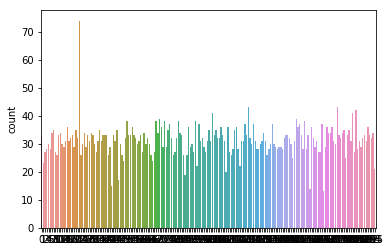

In [11]:
# ensemble result.....
if True:
    # ensemble~~~~~  mean value. 
    predictions = np.asarray(predictions)
    prk = np.mean(predictions, axis=0 )
    # index class. need to change to label.
    pdi = np.argmax(prk, axis=1)  
    print('ensemble class index:', pdi,  'min=', np.min(pdi), 'max=', np.max(pdi))
    sns.countplot(pdi)

In [12]:
# class to LABEL...
if True:
    # labeling k=label string, v=class number
#     label = dict((v,k) for k,v in train_generator.class_indices.items())
#     final_pred = [label[k] for k in pdi]
    
    n1=pd.DataFrame(list(range(1,197)), columns=['num']).astype('str')
    n2=n1.sort_values('num').values.squeeze()
    final_pred = [n2[k] for k in pdi]
    
    final_pred = np.asarray(final_pred, dtype=np.int)
    print('final:', final_pred)
    print('count=', len(final_pred))

final: [124  98 157 ...  44  50  94]
count= 6150


In [13]:
# debug result check
if bDebug:
    # evaluation (train data set. we knew the label.)
    reallabel = np.array(dftest['class'].values, dtype=int)
    print(reallabel)
    print( np.sum(final_pred==reallabel), '/', len(final_pred), len(reallabel))    

In [20]:
# make submission file.
if not bDebug:
    submission = pd.read_csv(inputdir+'sample_submission.csv')
    submission["class"] = final_pred  
    submission.to_csv("submission.csv", index=False)
    print(submission.head())

         img_file  class
0  test_00001.jpg    124
1  test_00002.jpg     98
2  test_00003.jpg    157
3  test_00004.jpg     94
4  test_00005.jpg     18


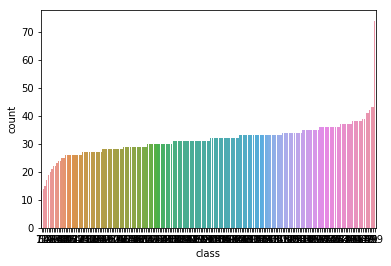

In [22]:
if not bDebug:
    sns.countplot(submission["class"], order=submission["class"].value_counts(ascending=True).index)   

In [31]:
# high rate predictions
dfpredictions = pd.DataFrame(np.max(prk, axis=1).squeeze(), columns=['maxPr'])
dfpredictions.head()

,maxPr
0,0.981348
1,0.999997
2,1.000000
3,0.983768
4,0.966001


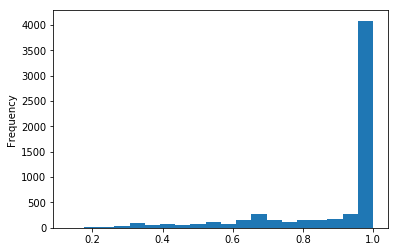

In [32]:
dfpredictions['maxPr'].plot.hist(bins=20)

In [36]:
psids = dfpredictions['maxPr']>0.99 
print( np.sum(psids) , '/', len(dfpredictions) )

3531 / 6150


In [45]:
if True:
    print('Create Pseudo Label')
    dfpseudo = pd.DataFrame( dftest.loc[psids, 'img_file'] )
    dfpseudo['class'] = final_pred[psids]
    dfpseudo.to_csv('pseudo.csv')

Create Pseudo Label


In [47]:
dfpseudo.head()

,img_file,class
1,test_00002.jpg,98
2,test_00003.jpg,157
6,test_00007.jpg,2
8,test_00009.jpg,191
9,test_00010.jpg,183
